In [1]:
import findspark
findspark.init('/home/ubuntu/spark-3.2.1-bin-hadoop2.7')
import pyspark
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName('HeartDiseaseAnalysis').getOrCreate()


Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/05/21 17:17:00 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
df = spark.read.format("csv").option("header", "true").option("inferSchema", "true").load("heart_2020_cleaned.csv")

df.printSchema()


root
 |-- HeartDisease: string (nullable = true)
 |-- BMI: double (nullable = true)
 |-- Smoking: string (nullable = true)
 |-- AlcoholDrinking: string (nullable = true)
 |-- Stroke: string (nullable = true)
 |-- PhysicalHealth: integer (nullable = true)
 |-- MentalHealth: integer (nullable = true)
 |-- DiffWalking: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- AgeCategory: string (nullable = true)
 |-- Race: string (nullable = true)
 |-- Diabetic: string (nullable = true)
 |-- PhysicalActivity: string (nullable = true)
 |-- GenHealth: string (nullable = true)
 |-- SleepTime: integer (nullable = true)
 |-- Asthma: string (nullable = true)
 |-- KidneyDisease: string (nullable = true)
 |-- SkinCancer: string (nullable = true)



In [3]:
df.show(5)

+------------+-----+-------+---------------+------+--------------+------------+-----------+------+-----------+-----+--------+----------------+---------+---------+------+-------------+----------+
|HeartDisease|  BMI|Smoking|AlcoholDrinking|Stroke|PhysicalHealth|MentalHealth|DiffWalking|   Sex|AgeCategory| Race|Diabetic|PhysicalActivity|GenHealth|SleepTime|Asthma|KidneyDisease|SkinCancer|
+------------+-----+-------+---------------+------+--------------+------------+-----------+------+-----------+-----+--------+----------------+---------+---------+------+-------------+----------+
|          No| 16.6|    Yes|             No|    No|             3|          30|         No|Female|      55-59|White|     Yes|             Yes|Very good|        5|   Yes|           No|       Yes|
|          No|20.34|     No|             No|   Yes|             0|           0|         No|Female|80 or older|White|      No|             Yes|Very good|        7|    No|           No|        No|
|          No|26.58|    Y

In [4]:
df.columns

['HeartDisease',
 'BMI',
 'Smoking',
 'AlcoholDrinking',
 'Stroke',
 'PhysicalHealth',
 'MentalHealth',
 'DiffWalking',
 'Sex',
 'AgeCategory',
 'Race',
 'Diabetic',
 'PhysicalActivity',
 'GenHealth',
 'SleepTime',
 'Asthma',
 'KidneyDisease',
 'SkinCancer']

In [5]:
from pyspark.sql.functions import col, when

df = df.withColumn("HeartDisease", when(col("HeartDisease") == "Yes", 1).otherwise(0))

df = df.withColumn("SleepTime", col("SleepTime").cast("integer"))


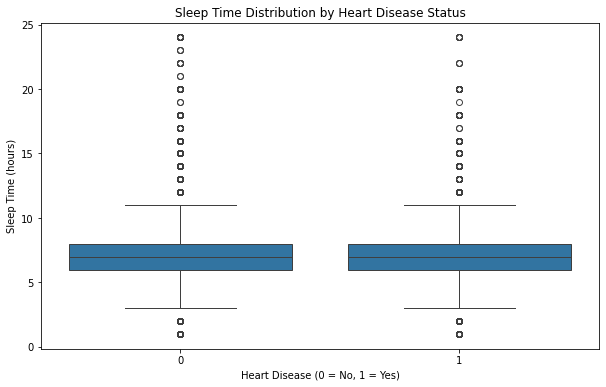

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pandas_df = df.toPandas()

plt.figure(figsize=(10, 6))
sns.boxplot(x='HeartDisease', y='SleepTime', data=pandas_df)
plt.title('Sleep Time Distribution by Heart Disease Status')
plt.xlabel('Heart Disease (0 = No, 1 = Yes)')
plt.ylabel('Sleep Time (hours)')
plt.show()


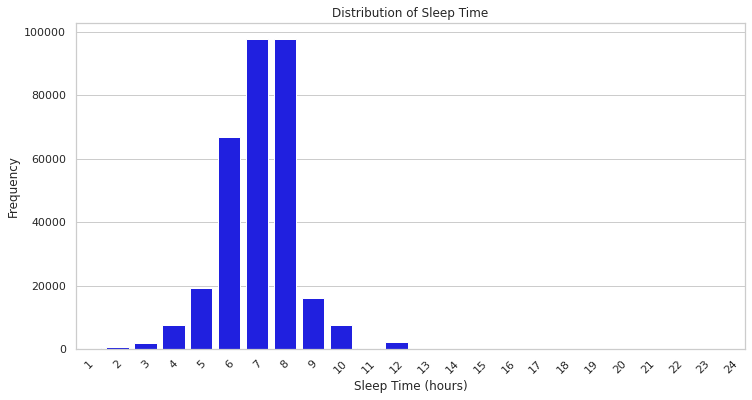

In [7]:
from pyspark.sql.functions import col
sleep_time_counts = df.groupBy("SleepTime").count().orderBy("SleepTime")
sleep_time_pd = sleep_time_counts.toPandas()
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
sns.barplot(x='SleepTime', y='count', data=sleep_time_pd, color='blue')
plt.title('Distribution of Sleep Time')
plt.xlabel('Sleep Time (hours)')
plt.ylabel('Frequency')
plt.xticks(rotation=45)  
plt.show()

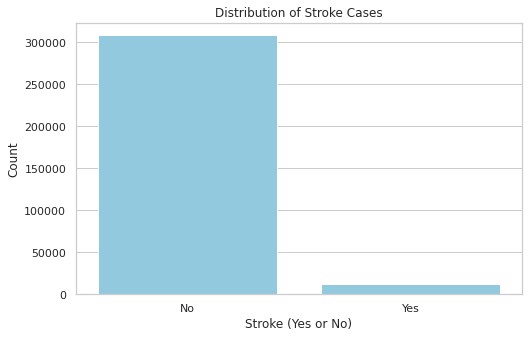

In [8]:
stroke_counts = df.groupBy("Stroke").count()
stroke_counts_pd = stroke_counts.toPandas()
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
plt.figure(figsize=(8, 5))
sns.barplot(x='Stroke', y='count', data=stroke_counts_pd, color='skyblue') 
plt.title('Distribution of Stroke Cases')
plt.xlabel('Stroke (Yes or No)')
plt.ylabel('Count')
plt.show()

In [9]:
from pyspark.sql.functions import when

columns_to_reclassify = [
    'Smoking', 'AlcoholDrinking', 'Stroke', 'DiffWalking', 'Diabetic', 
    'PhysicalActivity', 'Asthma', 'KidneyDisease', 'SkinCancer'
]

for column in columns_to_reclassify:
    if column in df.columns:
        df = df.withColumn(column, when(df[column] == "Yes", 1).otherwise(0))
    else:
        print(f"Column {column} not found in the dataset.")


In [10]:
df.show()

+------------+-----+-------+---------------+------+--------------+------------+-----------+------+-----------+-----+--------+----------------+---------+---------+------+-------------+----------+
|HeartDisease|  BMI|Smoking|AlcoholDrinking|Stroke|PhysicalHealth|MentalHealth|DiffWalking|   Sex|AgeCategory| Race|Diabetic|PhysicalActivity|GenHealth|SleepTime|Asthma|KidneyDisease|SkinCancer|
+------------+-----+-------+---------------+------+--------------+------------+-----------+------+-----------+-----+--------+----------------+---------+---------+------+-------------+----------+
|           0| 16.6|      1|              0|     0|             3|          30|          0|Female|      55-59|White|       1|               1|Very good|        5|     1|            0|         1|
|           0|20.34|      0|              0|     1|             0|           0|          0|Female|80 or older|White|       0|               1|Very good|        7|     0|            0|         0|
|           0|26.58|     

In [11]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, when, isnan, isnull
from pyspark.sql.types import IntegerType, DoubleType

spark = SparkSession.builder.appName("DataQualityReport").getOrCreate()

def count_nulls(c):
    return count(when(isnan(c) | col(c).isNull(), c))

desc_stats = df.describe()

null_counts = df.select([count_nulls(c).alias(c) for c in df.columns])

numeric_columns = [f.name for f in df.schema.fields if isinstance(f.dataType, (IntegerType, DoubleType))]

extreme_thresholds = {
    'PhysicalHealth': 20,  
    'MentalHealth': 20,    
    'SleepTime': (4, 12),  
    'BMI': (15, 40)       
}

extreme_values = df.select([
    count(when((col(c) < extreme_thresholds[c][0]) | (col(c) > extreme_thresholds[c][1]), c)).alias(c)
    if c in extreme_thresholds and isinstance(extreme_thresholds[c], tuple) else
    count(when(col(c) > extreme_thresholds[c], c)).alias(c)
    if c in extreme_thresholds else
    count(when(col(c) > 100, c)).alias(c) 
    for c in numeric_columns
])

desc_stats.show()

null_counts.show()

extreme_values.show()


+-------+-------------------+------------------+-------------------+-------------------+-------------------+------------------+-----------------+------------------+------+-----------+--------------------+-------------------+-------------------+---------+------------------+-------------------+--------------------+-------------------+
|summary|       HeartDisease|               BMI|            Smoking|    AlcoholDrinking|             Stroke|    PhysicalHealth|     MentalHealth|       DiffWalking|   Sex|AgeCategory|                Race|           Diabetic|   PhysicalActivity|GenHealth|         SleepTime|             Asthma|       KidneyDisease|         SkinCancer|
+-------+-------------------+------------------+-------------------+-------------------+-------------------+------------------+-----------------+------------------+------+-----------+--------------------+-------------------+-------------------+---------+------------------+-------------------+--------------------+----------------

+------------+---+-------+---------------+------+--------------+------------+-----------+---+-----------+----+--------+----------------+---------+---------+------+-------------+----------+
|HeartDisease|BMI|Smoking|AlcoholDrinking|Stroke|PhysicalHealth|MentalHealth|DiffWalking|Sex|AgeCategory|Race|Diabetic|PhysicalActivity|GenHealth|SleepTime|Asthma|KidneyDisease|SkinCancer|
+------------+---+-------+---------------+------+--------------+------------+-----------+---+-----------+----+--------+----------------+---------+---------+------+-------------+----------+
|           0|  0|      0|              0|     0|             0|           0|          0|  0|          0|   0|       0|               0|        0|        0|     0|            0|         0|
+------------+---+-------+---------------+------+--------------+------------+-----------+---+-----------+----+--------+----------------+---------+---------+------+-------------+----------+



+------------+-----+-------+---------------+------+--------------+------------+-----------+--------+----------------+---------+------+-------------+----------+
|HeartDisease|  BMI|Smoking|AlcoholDrinking|Stroke|PhysicalHealth|MentalHealth|DiffWalking|Diabetic|PhysicalActivity|SleepTime|Asthma|KidneyDisease|SkinCancer|
+------------+-----+-------+---------------+------+--------------+------------+-----------+--------+----------------+---------+------+-------------+----------+
|           0|16641|      0|              0|     0|         22341|       20929|          0|       0|               0|     4330|     0|            0|         0|
+------------+-----+-------+---------------+------+--------------+------------+-----------+--------+----------------+---------+------+-------------+----------+



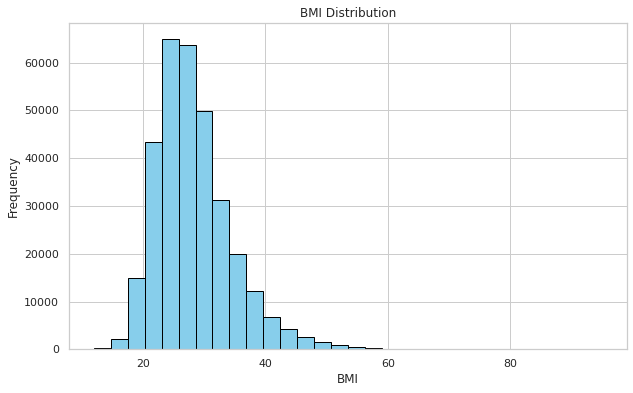

In [12]:
import matplotlib.pyplot as plt

bmi_pdf = df.select('BMI').toPandas()

plt.figure(figsize=(10, 6))
plt.hist(bmi_pdf['BMI'], bins=30, color='skyblue', edgecolor='black')
plt.title('BMI Distribution')
plt.xlabel('BMI')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


In [13]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("DataFiltering").getOrCreate()
df_filtered = df.drop('Sex', 'Race', 'Asthma')

In [14]:
df_filtered.printSchema()



root
 |-- HeartDisease: integer (nullable = false)
 |-- BMI: double (nullable = true)
 |-- Smoking: integer (nullable = false)
 |-- AlcoholDrinking: integer (nullable = false)
 |-- Stroke: integer (nullable = false)
 |-- PhysicalHealth: integer (nullable = true)
 |-- MentalHealth: integer (nullable = true)
 |-- DiffWalking: integer (nullable = false)
 |-- AgeCategory: string (nullable = true)
 |-- Diabetic: integer (nullable = false)
 |-- PhysicalActivity: integer (nullable = false)
 |-- GenHealth: string (nullable = true)
 |-- SleepTime: integer (nullable = true)
 |-- KidneyDisease: integer (nullable = false)
 |-- SkinCancer: integer (nullable = false)



In [15]:
df_filtered.show()

+------------+-----+-------+---------------+------+--------------+------------+-----------+-----------+--------+----------------+---------+---------+-------------+----------+
|HeartDisease|  BMI|Smoking|AlcoholDrinking|Stroke|PhysicalHealth|MentalHealth|DiffWalking|AgeCategory|Diabetic|PhysicalActivity|GenHealth|SleepTime|KidneyDisease|SkinCancer|
+------------+-----+-------+---------------+------+--------------+------------+-----------+-----------+--------+----------------+---------+---------+-------------+----------+
|           0| 16.6|      1|              0|     0|             3|          30|          0|      55-59|       1|               1|Very good|        5|            0|         1|
|           0|20.34|      0|              0|     1|             0|           0|          0|80 or older|       0|               1|Very good|        7|            0|         0|
|           0|26.58|      1|              0|     0|            20|          30|          0|      65-69|       1|             

In [16]:
from pyspark.sql.functions import col

extreme_thresholds = {
    'PhysicalHealth': 20,  
    'MentalHealth': 20,   
    'SleepTime': (4, 12), 
    'BMI': (15, 40)       
}

for key, value in extreme_thresholds.items():
    if isinstance(value, tuple):
        df_filtered = df_filtered.filter((col(key) >= value[0]) & (col(key) <= value[1]))
    else:
        df_filtered = df_filtered.filter(col(key) <= value)
print("Filtered DataFrame Schema:")
df_filtered.printSchema()
print("Sample Data from Filtered DataFrame:")
df_filtered.show(5)


Filtered DataFrame Schema:
root
 |-- HeartDisease: integer (nullable = false)
 |-- BMI: double (nullable = true)
 |-- Smoking: integer (nullable = false)
 |-- AlcoholDrinking: integer (nullable = false)
 |-- Stroke: integer (nullable = false)
 |-- PhysicalHealth: integer (nullable = true)
 |-- MentalHealth: integer (nullable = true)
 |-- DiffWalking: integer (nullable = false)
 |-- AgeCategory: string (nullable = true)
 |-- Diabetic: integer (nullable = false)
 |-- PhysicalActivity: integer (nullable = false)
 |-- GenHealth: string (nullable = true)
 |-- SleepTime: integer (nullable = true)
 |-- KidneyDisease: integer (nullable = false)
 |-- SkinCancer: integer (nullable = false)

Sample Data from Filtered DataFrame:
+------------+-----+-------+---------------+------+--------------+------------+-----------+-----------+--------+----------------+---------+---------+-------------+----------+
|HeartDisease|  BMI|Smoking|AlcoholDrinking|Stroke|PhysicalHealth|MentalHealth|DiffWalking|AgeCate

In [17]:
from pyspark.sql.functions import col

extreme_value_counts = {
    'PhysicalHealth': df_filtered.filter(col('PhysicalHealth') > 20).count(),
    'MentalHealth': df_filtered.filter(col('MentalHealth') > 20).count(),
    'SleepTime': df_filtered.filter((col('SleepTime') < 4) | (col('SleepTime') > 12)).count(),
    'BMI': df_filtered.filter((col('BMI') < 15) | (col('BMI') > 40)).count()
}

print("Counts of extreme values after filtering:")
for key, value in extreme_value_counts.items():
    print(f"{key}: {value}")


Counts of extreme values after filtering:
PhysicalHealth: 0
MentalHealth: 0
SleepTime: 0
BMI: 0


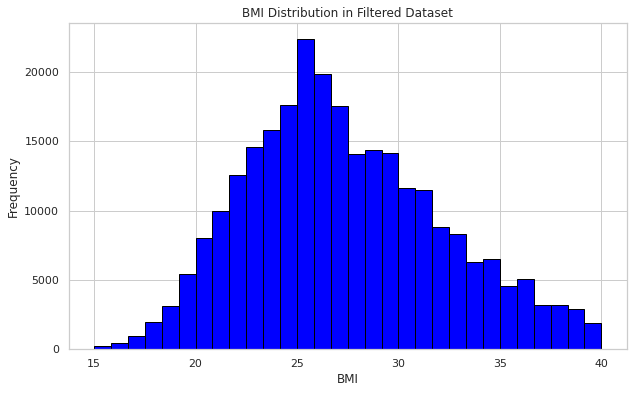

In [18]:
import matplotlib.pyplot as plt
import pandas as pd

bmi_pdf = df_filtered.select('BMI').toPandas()

plt.figure(figsize=(10, 6))
plt.hist(bmi_pdf['BMI'], bins=30, color='blue', edgecolor='black')
plt.title('BMI Distribution in Filtered Dataset')
plt.xlabel('BMI')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


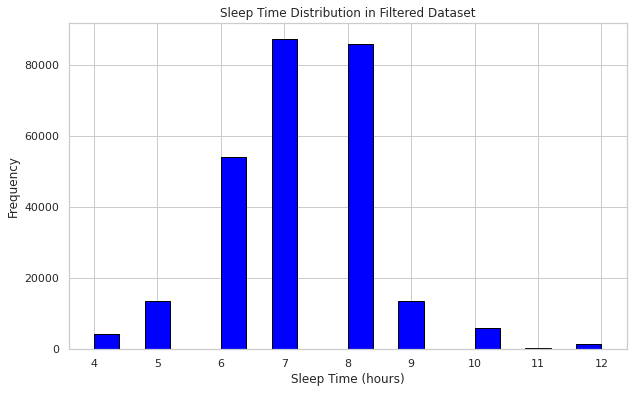

In [19]:
import matplotlib.pyplot as plt
import pandas as pd

sleep_time_pdf = df_filtered.select('SleepTime').toPandas()

plt.figure(figsize=(10, 6))
plt.hist(sleep_time_pdf['SleepTime'], bins=20, color='blue', edgecolor='black')
plt.title('Sleep Time Distribution in Filtered Dataset')
plt.xlabel('Sleep Time (hours)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [20]:
from pyspark.sql.functions import col

bmi_lower_bound = 18.5
bmi_upper_bound = 24.9

selected_data = df_filtered.filter(
    (col('PhysicalHealth') > 0) &
    (col('MentalHealth') > 0) &
    (col('BMI') >= bmi_lower_bound) &
    (col('BMI') <= bmi_upper_bound)
)

selected_data.show()

+------------+-----+-------+---------------+------+--------------+------------+-----------+-----------+--------+----------------+---------+---------+-------------+----------+
|HeartDisease|  BMI|Smoking|AlcoholDrinking|Stroke|PhysicalHealth|MentalHealth|DiffWalking|AgeCategory|Diabetic|PhysicalActivity|GenHealth|SleepTime|KidneyDisease|SkinCancer|
+------------+-----+-------+---------------+------+--------------+------------+-----------+-----------+--------+----------------+---------+---------+-------------+----------+
|           0|20.43|      1|              0|     0|             3|           3|          0|      65-69|       0|               1|     Fair|        5|            0|         1|
|           0|21.93|      0|              0|     0|             3|           2|          0|      70-74|       0|               1|     Fair|        4|            1|         0|
|           0|24.13|      0|              0|     0|             6|          15|          0|      60-64|       0|             

In [21]:
from pyspark.sql.functions import col, when

selected_data = selected_data.withColumn(
    'SleepTime02',
    when(col('SleepTime') <= 6, 'unhealthy').otherwise('healthy')
)

selected_data.show()

+------------+-----+-------+---------------+------+--------------+------------+-----------+-----------+--------+----------------+---------+---------+-------------+----------+-----------+
|HeartDisease|  BMI|Smoking|AlcoholDrinking|Stroke|PhysicalHealth|MentalHealth|DiffWalking|AgeCategory|Diabetic|PhysicalActivity|GenHealth|SleepTime|KidneyDisease|SkinCancer|SleepTime02|
+------------+-----+-------+---------------+------+--------------+------------+-----------+-----------+--------+----------------+---------+---------+-------------+----------+-----------+
|           0|20.43|      1|              0|     0|             3|           3|          0|      65-69|       0|               1|     Fair|        5|            0|         1|  unhealthy|
|           0|21.93|      0|              0|     0|             3|           2|          0|      70-74|       0|               1|     Fair|        4|            1|         0|  unhealthy|
|           0|24.13|      0|              0|     0|             6

In [22]:
selected_data.select("SleepTime02").show()

+-----------+
|SleepTime02|
+-----------+
|  unhealthy|
|  unhealthy|
|    healthy|
|    healthy|
|    healthy|
|    healthy|
|    healthy|
|    healthy|
|  unhealthy|
|    healthy|
|    healthy|
|  unhealthy|
|    healthy|
|    healthy|
|    healthy|
|    healthy|
|    healthy|
|    healthy|
|  unhealthy|
|    healthy|
+-----------+
only showing top 20 rows



In [23]:
df_heart_disease = spark.read.format("csv").option("header", "true").option("inferSchema", "true").load("heart_disease.csv")

merged_data = selected_data.join(df_heart_disease, "BMI", "inner")

merged_data.show()

24/05/21 17:19:17 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-----+------------+-------+---------------+------+--------------+------------+-----------+-----------+--------+----------------+---------+---------+-------------+----------+-----------+------+---+-------------+-------------+----------+------+---------------+------------+--------+-------+-----+-----+---------+-------+-------------+
|  BMI|HeartDisease|Smoking|AlcoholDrinking|Stroke|PhysicalHealth|MentalHealth|DiffWalking|AgeCategory|Diabetic|PhysicalActivity|GenHealth|SleepTime|KidneyDisease|SkinCancer|SleepTime02|Gender|age|    education|currentSmoker|cigsPerDay|BPMeds|prevalentStroke|prevalentHyp|diabetes|totChol|sysBP|diaBP|heartRate|glucose|Heart_ stroke|
+-----+------------+-------+---------------+------+--------------+------------+-----------+-----------+--------+----------------+---------+---------+-------------+----------+-----------+------+---+-------------+-------------+----------+------+---------------+------------+--------+-------+-----+-----+---------+-------+-------------

In [24]:
columns_to_drop = ['Gender', 'age', 'currentSmoker', 'cigsPerDay', 'BPMeds', 'prevalentStroke', 'prevalentHyp', 'totChol', 'sysBP', 'diaBP', 'heartRate', 'glucose', 'Heart_ stroke', 'SleepTime', 'AlcoholDrinking', 'Stroke', 'KidneyDisease', 'diabetes']
merged_data_cleaned = merged_data.drop(*columns_to_drop)

print("DataFrame schema:")
merged_data_cleaned.printSchema()

print("Total number of rows:", merged_data_cleaned.count())

DataFrame schema:
root
 |-- BMI: double (nullable = true)
 |-- HeartDisease: integer (nullable = false)
 |-- Smoking: integer (nullable = false)
 |-- PhysicalHealth: integer (nullable = true)
 |-- MentalHealth: integer (nullable = true)
 |-- DiffWalking: integer (nullable = false)
 |-- AgeCategory: string (nullable = true)
 |-- Diabetic: integer (nullable = false)
 |-- PhysicalActivity: integer (nullable = false)
 |-- GenHealth: string (nullable = true)
 |-- SkinCancer: integer (nullable = false)
 |-- SleepTime02: string (nullable = false)
 |-- education: string (nullable = true)



Total number of rows: 28353


In [25]:
merged_data_cleaned.show()

+-----+------------+-------+--------------+------------+-----------+-----------+--------+----------------+---------+----------+-----------+-------------+
|  BMI|HeartDisease|Smoking|PhysicalHealth|MentalHealth|DiffWalking|AgeCategory|Diabetic|PhysicalActivity|GenHealth|SkinCancer|SleepTime02|    education|
+-----+------------+-------+--------------+------------+-----------+-----------+--------+----------------+---------+----------+-----------+-------------+
|20.43|           0|      1|             3|           3|          0|      65-69|       0|               1|     Fair|         1|  unhealthy|     graduate|
|21.93|           0|      0|             3|           2|          0|      70-74|       0|               1|     Fair|         0|  unhealthy|primaryschool|
|21.93|           0|      0|             3|           2|          0|      70-74|       0|               1|     Fair|         0|  unhealthy|primaryschool|
|21.93|           0|      0|             3|           2|          0|      70

In [26]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.sql.types import StructType, StructField, StringType, FloatType
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml import Pipeline

spark = SparkSession.builder.appName("FeatureImportance").getOrCreate()

feature_columns = [col for col in merged_data_cleaned.columns if col != 'HeartDisease']  

string_features = ['AgeCategory', 'GenHealth', 'SleepTime02', 'education']
indexers = [StringIndexer(inputCol=column, outputCol=column+"_index").setHandleInvalid("keep") for column in string_features]

label_indexer = StringIndexer(inputCol='HeartDisease', outputCol='label').setHandleInvalid("keep")

feature_columns_updated = [col+"_index" for col in string_features] + \
                          [col for col in feature_columns if col not in string_features]

assembler = VectorAssembler(inputCols=feature_columns_updated, outputCol="features")

rf = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=10)

pipeline = Pipeline(stages=indexers + [label_indexer, assembler, rf])

model = pipeline.fit(merged_data_cleaned)

importances = model.stages[-1].featureImportances

feature_importances_list = [(feature_columns_updated[i], float(importances[i])) for i in range(len(feature_columns_updated)) if importances[i] > 0]
schema = StructType([StructField("Feature", StringType(), True), StructField("Importance", FloatType(), True)])
feature_importances_df = spark.createDataFrame(feature_importances_list, schema=schema)

feature_importances_df.orderBy(col("Importance").desc()).show()


+-----------------+------------+
|          Feature|  Importance|
+-----------------+------------+
|AgeCategory_index|    0.472482|
|  GenHealth_index|  0.26708698|
|         Diabetic|   0.0949588|
|              BMI|  0.03433641|
|      DiffWalking| 0.031506665|
|   PhysicalHealth| 0.029034255|
|     MentalHealth| 0.021492338|
|SleepTime02_index|  0.01646688|
|       SkinCancer|0.0137217725|
| PhysicalActivity| 0.009759235|
|          Smoking|0.0072708437|
|  education_index| 0.001883811|
+-----------------+------------+



In [27]:
merged_data_cleaned = merged_data_cleaned.drop('education')

merged_data_cleaned.printSchema()

root
 |-- BMI: double (nullable = true)
 |-- HeartDisease: integer (nullable = false)
 |-- Smoking: integer (nullable = false)
 |-- PhysicalHealth: integer (nullable = true)
 |-- MentalHealth: integer (nullable = true)
 |-- DiffWalking: integer (nullable = false)
 |-- AgeCategory: string (nullable = true)
 |-- Diabetic: integer (nullable = false)
 |-- PhysicalActivity: integer (nullable = false)
 |-- GenHealth: string (nullable = true)
 |-- SkinCancer: integer (nullable = false)
 |-- SleepTime02: string (nullable = false)



In [39]:
from pyspark.sql.functions import log, sqrt, lit, col

df = df.withColumn("BMI_log", log('BMI'))
df = df.withColumn("PhysicalHealth_log", log('PhysicalHealth'))
df = df.withColumn("MentalHealth_log", log('MentalHealth'))

df = df.withColumn("BMI_log10", log(col("BMI")) / log(lit(10)))
df = df.withColumn("PhysicalHealth_log10", log(col("PhysicalHealth")) / log(lit(10)))
df = df.withColumn("MentalHealth_log10", log(col("MentalHealth")) / log(lit(10)))

df = df.withColumn("BMI_sqrt", sqrt('BMI'))
df = df.withColumn("PhysicalHealth_sqrt", sqrt('PhysicalHealth'))
df = df.withColumn("MentalHealth_sqrt", sqrt('MentalHealth'))

df.printSchema()

df.select('BMI', 'BMI_log', 'BMI_log10', 'BMI_sqrt', 
          'PhysicalHealth', 'PhysicalHealth_log', 'PhysicalHealth_log10', 'PhysicalHealth_sqrt',
          'MentalHealth', 'MentalHealth_log', 'MentalHealth_log10', 'MentalHealth_sqrt').show()


root
 |-- HeartDisease: integer (nullable = false)
 |-- BMI: double (nullable = true)
 |-- Smoking: integer (nullable = false)
 |-- AlcoholDrinking: integer (nullable = false)
 |-- Stroke: integer (nullable = false)
 |-- PhysicalHealth: integer (nullable = true)
 |-- MentalHealth: integer (nullable = true)
 |-- DiffWalking: integer (nullable = false)
 |-- Sex: string (nullable = true)
 |-- AgeCategory: string (nullable = true)
 |-- Race: string (nullable = true)
 |-- Diabetic: integer (nullable = false)
 |-- PhysicalActivity: integer (nullable = false)
 |-- GenHealth: string (nullable = true)
 |-- SleepTime: integer (nullable = true)
 |-- Asthma: integer (nullable = false)
 |-- KidneyDisease: integer (nullable = false)
 |-- SkinCancer: integer (nullable = false)
 |-- BMI_log: double (nullable = true)
 |-- PhysicalHealth_log: double (nullable = true)
 |-- MentalHealth_log: double (nullable = true)
 |-- BMI_log10: double (nullable = true)
 |-- PhysicalHealth_log10: double (nullable = tru

In [28]:
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
from pyspark.sql.functions import col

string_columns = ['AgeCategory', 'GenHealth', 'SleepTime02']

indexers = [StringIndexer(inputCol=column, outputCol=column+"_index").setHandleInvalid("keep") for column in string_columns]

feature_columns = [col+"_index" if col in string_columns else col for col in merged_data_cleaned.columns if col != 'HeartDisease']

assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

logr = LogisticRegression(featuresCol="features", labelCol="HeartDisease")

pipeline = Pipeline(stages=indexers + [assembler, logr])

model = pipeline.fit(merged_data_cleaned)

In [29]:
summary = model.stages[-1].summary
print("Area under ROC:", summary.areaUnderROC)

Area under ROC: 0.8092997871272694


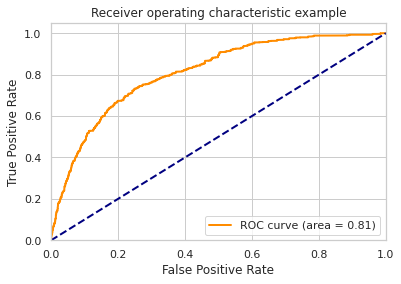

In [30]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

predictions = model.transform(merged_data_cleaned)
pandas_df = predictions.select(['probability', 'HeartDisease']).toPandas()
fpr, tpr, _ = roc_curve(pandas_df['HeartDisease'], pandas_df['probability'].apply(lambda x: x[1]))
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [31]:
from pyspark.ml.feature import StringIndexer, VectorAssembler, OneHotEncoder
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml import Pipeline
from pyspark.sql.functions import col

string_columns = ['AgeCategory', 'GenHealth', 'SleepTime02']

indexers = [StringIndexer(inputCol=c, outputCol=c+"_index").setHandleInvalid("skip") for c in string_columns]

encoders = [OneHotEncoder(inputCol=c+"_index", outputCol=c+"_encoded") for c in string_columns]

feature_columns = [c+"_encoded" for c in string_columns] + \
                  [c for c in merged_data_cleaned.columns if c not in string_columns and c != 'HeartDisease']

assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

dt = DecisionTreeClassifier(featuresCol="features", labelCol="HeartDisease")

pipeline = Pipeline(stages=indexers + encoders + [assembler, dt])

model = pipeline.fit(merged_data_cleaned)

treeModel = model.stages[-1]
print("Learned classification tree model:\n", treeModel.toDebugString)

Learned classification tree model:
 DecisionTreeClassificationModel: uid=DecisionTreeClassifier_cbea9867860f, depth=5, numNodes=45, numClasses=2, numFeatures=25
  If (feature 11 in {1.0})
   If (feature 22 <= 0.5)
    If (feature 17 <= 24.4)
     Predict: 0.0
    Else (feature 17 > 24.4)
     If (feature 17 <= 24.705)
      If (feature 16 in {1.0})
       Predict: 0.0
      Else (feature 16 not in {1.0})
       Predict: 1.0
     Else (feature 17 > 24.705)
      If (feature 20 <= 12.5)
       Predict: 0.0
      Else (feature 20 > 12.5)
       Predict: 1.0
   Else (feature 22 > 0.5)
    If (feature 20 <= 6.5)
     If (feature 17 <= 24.025)
      If (feature 20 <= 3.5)
       Predict: 1.0
      Else (feature 20 > 3.5)
       Predict: 0.0
     Else (feature 17 > 24.025)
      If (feature 24 <= 0.5)
       Predict: 0.0
      Else (feature 24 > 0.5)
       Predict: 1.0
    Else (feature 20 > 6.5)
     If (feature 20 <= 10.5)
      If (feature 17 <= 24.705)
       Predict: 1.0
      Else (fea

In [32]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

predictions = model.transform(merged_data_cleaned)

evaluator = BinaryClassificationEvaluator(labelCol="HeartDisease", rawPredictionCol="probability", metricName="areaUnderROC")

auc = evaluator.evaluate(predictions)

print("Area under ROC for Decision Tree model:", auc)

Area under ROC for Decision Tree model: 0.7734171283962201


In [33]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(featuresCol="features", labelCol="HeartDisease", numTrees=10)

rf_pipeline = Pipeline(stages=indexers + encoders + [assembler, rf])

rf_model = rf_pipeline.fit(merged_data_cleaned)

rf_predictions = rf_model.transform(merged_data_cleaned)

rf_evaluator = BinaryClassificationEvaluator(labelCol="HeartDisease", rawPredictionCol="rawPrediction", metricName="areaUnderROC")

rf_auc = rf_evaluator.evaluate(rf_predictions)

print("RFC")
print(rf_auc)


RFC
0.8302085573309925


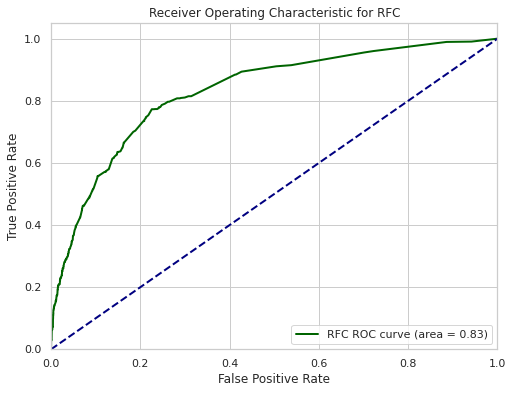

In [34]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
rf_prob = rf_predictions.select("probability").rdd.map(lambda row: row[0][1]).collect()
rf_label = rf_predictions.select("HeartDisease").rdd.map(lambda row: row[0]).collect()
rf_fpr, rf_tpr, _ = roc_curve(rf_label, rf_prob)
rf_roc_auc = auc(rf_fpr, rf_tpr)
plt.figure(figsize=(8, 6))
plt.plot(rf_fpr, rf_tpr, color='darkgreen', lw=2, label='RFC ROC curve (area = %0.2f)' % rf_roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for RFC')
plt.legend(loc="lower right")
plt.show()

In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
rf = RandomForestClassifier(featuresCol="features", labelCol="HeartDisease", numTrees=10)
rf_pipeline = Pipeline(stages=indexers + encoders + [assembler, rf])
paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [10, 20, 50, 100]) \
    .addGrid(rf.maxDepth, [5, 10, 15, 20]) \
    .addGrid(rf.maxBins, [32, 40, 48]) \
    .addGrid(rf.minInstancesPerNode, [1, 2, 4]) \
    .build()
evaluator = BinaryClassificationEvaluator(
    labelCol="HeartDisease",
    rawPredictionCol="rawPrediction",
    metricName="areaUnderROC"
)
cv = CrossValidator(
    estimator=rf_pipeline,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator,
    numFolds=5,
    parallelism=4
)
cvModel = cv.fit(merged_data_cleaned)
bestModel = cvModel.bestModel
bestPredictions = bestModel.transform(merged_data_cleaned)
bestAuc = evaluator.evaluate(bestPredictions)
print("RFC Best Model AUC:", bestAuc)
bestRFModel = bestModel.stages[-1]
print("Best Model Params:")
print(" - numTrees: ", bestRFModel.getNumTrees)
print(" - maxDepth: ", bestRFModel.getDepth())
print(" - maxBins: ", bestRFModel.getMaxBins())
print(" - minInstancesPerNode: ", bestRFModel.getMinInstancesPerNode())


24/05/21 15:23:56 WARN DAGScheduler: Broadcasting large task binary with size 1128.3 KiB
24/05/21 15:23:56 WARN DAGScheduler: Broadcasting large task binary with size 1252.3 KiB
24/05/21 15:23:57 WARN DAGScheduler: Broadcasting large task binary with size 1080.8 KiB
24/05/21 15:23:58 WARN DAGScheduler: Broadcasting large task binary with size 1202.9 KiB
24/05/21 15:24:04 WARN DAGScheduler: Broadcasting large task binary with size 1064.5 KiB
24/05/21 15:24:06 WARN DAGScheduler: Broadcasting large task binary with size 1121.7 KiB
24/05/21 15:24:07 WARN DAGScheduler: Broadcasting large task binary with size 1238.2 KiB
24/05/21 15:24:10 WARN DAGScheduler: Broadcasting large task binary with size 1095.8 KiB
24/05/21 15:24:11 WARN DAGScheduler: Broadcasting large task binary with size 1210.0 KiB
24/05/21 15:24:12 WARN DAGScheduler: Broadcasting large task binary with size 1019.4 KiB
24/05/21 15:24:13 WARN DAGScheduler: Broadcasting large task binary with size 1114.1 KiB
24/05/21 15:24:18 WAR

24/05/21 15:25:57 WARN DAGScheduler: Broadcasting large task binary with size 1521.1 KiB
24/05/21 15:25:57 WARN DAGScheduler: Broadcasting large task binary with size 1213.1 KiB
24/05/21 15:25:58 WARN DAGScheduler: Broadcasting large task binary with size 1769.6 KiB
24/05/21 15:25:58 WARN DAGScheduler: Broadcasting large task binary with size 1429.3 KiB
24/05/21 15:25:59 WARN DAGScheduler: Broadcasting large task binary with size 2000.6 KiB
24/05/21 15:25:59 WARN DAGScheduler: Broadcasting large task binary with size 1643.5 KiB
24/05/21 15:26:00 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
24/05/21 15:26:00 WARN DAGScheduler: Broadcasting large task binary with size 1844.6 KiB
24/05/21 15:26:01 WARN DAGScheduler: Broadcasting large task binary with size 1062.5 KiB
24/05/21 15:26:01 WARN DAGScheduler: Broadcasting large task binary with size 2029.4 KiB
24/05/21 15:26:04 WARN DAGScheduler: Broadcasting large task binary with size 1051.1 KiB
24/05/21 15:26:05 WARN D

24/05/21 15:27:01 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB
24/05/21 15:27:01 WARN DAGScheduler: Broadcasting large task binary with size 1310.4 KiB
24/05/21 15:27:01 WARN DAGScheduler: Broadcasting large task binary with size 1578.1 KiB
24/05/21 15:27:02 WARN DAGScheduler: Broadcasting large task binary with size 1712.4 KiB
24/05/21 15:27:02 WARN DAGScheduler: Broadcasting large task binary with size 1838.2 KiB
24/05/21 15:27:03 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
24/05/21 15:27:04 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
24/05/21 15:27:05 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
24/05/21 15:27:06 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
24/05/21 15:27:06 WARN DAGScheduler: Broadcasting large task binary with size 1222.3 KiB
24/05/21 15:27:07 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
24/05/21 15:27:07 WARN DAGScheduler: Br

24/05/21 15:30:40 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
24/05/21 15:30:41 WARN DAGScheduler: Broadcasting large task binary with size 6.1 MiB
24/05/21 15:30:42 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
24/05/21 15:30:44 WARN DAGScheduler: Broadcasting large task binary with size 6.6 MiB
24/05/21 15:30:45 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/05/21 15:30:48 WARN DAGScheduler: Broadcasting large task binary with size 7.0 MiB
24/05/21 15:30:48 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
24/05/21 15:30:50 WARN DAGScheduler: Broadcasting large task binary with size 7.3 MiB
24/05/21 15:30:50 WARN DAGScheduler: Broadcasting large task binary with size 5.3 MiB
24/05/21 15:30:53 WARN DAGScheduler: Broadcasting large task binary with size 7.6 MiB
24/05/21 15:30:53 WARN DAGScheduler: Broadcasting large task binary with size 5.8 MiB
24/05/21 15:30:57 WARN DAGScheduler: Broadcasting larg

24/05/21 15:36:29 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB
24/05/21 15:36:30 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
24/05/21 15:36:31 WARN DAGScheduler: Broadcasting large task binary with size 1473.2 KiB
24/05/21 15:36:33 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
24/05/21 15:36:36 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
24/05/21 15:36:38 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
24/05/21 15:36:41 WARN DAGScheduler: Broadcasting large task binary with size 1467.8 KiB
24/05/21 15:36:42 WARN DAGScheduler: Broadcasting large task binary with size 5.8 MiB
24/05/21 15:36:44 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
24/05/21 15:36:45 WARN DAGScheduler: Broadcasting large task binary with size 7.1 MiB
24/05/21 15:36:48 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
24/05/21 15:36:49 WARN DAGScheduler: Broadcastin

24/05/21 15:43:53 WARN DAGScheduler: Broadcasting large task binary with size 14.1 MiB
24/05/21 15:43:54 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
24/05/21 15:43:59 WARN DAGScheduler: Broadcasting large task binary with size 10.4 MiB
24/05/21 15:43:59 WARN DAGScheduler: Broadcasting large task binary with size 6.4 MiB
24/05/21 15:44:03 WARN DAGScheduler: Broadcasting large task binary with size 11.2 MiB
24/05/21 15:44:06 WARN DAGScheduler: Broadcasting large task binary with size 11.8 MiB
24/05/21 15:44:09 WARN DAGScheduler: Broadcasting large task binary with size 12.3 MiB
24/05/21 15:44:12 WARN DAGScheduler: Broadcasting large task binary with size 12.7 MiB
24/05/21 15:44:15 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB
24/05/21 15:44:55 WARN DAGScheduler: Broadcasting large task binary with size 1102.0 KiB
24/05/21 15:44:56 WARN DAGScheduler: Broadcasting large task binary with size 1219.0 KiB
24/05/21 15:44:57 WARN DAGScheduler: Broad

24/05/21 15:46:36 WARN DAGScheduler: Broadcasting large task binary with size 1531.7 KiB
24/05/21 15:46:36 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
24/05/21 15:46:37 WARN DAGScheduler: Broadcasting large task binary with size 1783.2 KiB
24/05/21 15:46:37 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
24/05/21 15:46:38 WARN DAGScheduler: Broadcasting large task binary with size 2018.3 KiB
24/05/21 15:46:39 WARN DAGScheduler: Broadcasting large task binary with size 1215.2 KiB
24/05/21 15:46:39 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
24/05/21 15:46:41 WARN DAGScheduler: Broadcasting large task binary with size 1081.5 KiB
24/05/21 15:46:42 WARN DAGScheduler: Broadcasting large task binary with size 1199.9 KiB
24/05/21 15:46:42 WARN DAGScheduler: Broadcasting large task binary with size 1440.6 KiB
24/05/21 15:46:43 WARN DAGScheduler: Broadcasting large task binary with size 1674.0 KiB
24/05/21 15:46:44 WARN DAGSche

24/05/21 15:47:42 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
24/05/21 15:47:43 WARN DAGScheduler: Broadcasting large task binary with size 2015.8 KiB
24/05/21 15:47:43 WARN DAGScheduler: Broadcasting large task binary with size 1198.3 KiB
24/05/21 15:47:43 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
24/05/21 15:47:44 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
24/05/21 15:47:44 WARN DAGScheduler: Broadcasting large task binary with size 1429.3 KiB
24/05/21 15:47:45 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
24/05/21 15:47:45 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
24/05/21 15:47:46 WARN DAGScheduler: Broadcasting large task binary with size 1646.5 KiB
24/05/21 15:47:46 WARN DAGScheduler: Broadcasting large task binary with size 1636.7 KiB
24/05/21 15:47:47 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
24/05/21 15:47:47 WARN DAGScheduler: Br

24/05/21 15:51:17 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
24/05/21 15:51:18 WARN DAGScheduler: Broadcasting large task binary with size 6.6 MiB
24/05/21 15:51:20 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
24/05/21 15:51:20 WARN DAGScheduler: Broadcasting large task binary with size 7.0 MiB
24/05/21 15:51:22 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB
24/05/21 15:51:23 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB
24/05/21 15:51:24 WARN DAGScheduler: Broadcasting large task binary with size 5.4 MiB
24/05/21 15:51:26 WARN DAGScheduler: Broadcasting large task binary with size 7.7 MiB
24/05/21 15:51:28 WARN DAGScheduler: Broadcasting large task binary with size 5.9 MiB
24/05/21 15:51:29 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
24/05/21 15:51:31 WARN DAGScheduler: Broadcasting large task binary with size 6.3 MiB
24/05/21 15:51:33 WARN DAGScheduler: Broadcasting larg

24/05/21 15:57:04 WARN DAGScheduler: Broadcasting large task binary with size 5.7 MiB
24/05/21 15:57:05 WARN DAGScheduler: Broadcasting large task binary with size 7.6 MiB
24/05/21 15:57:10 WARN DAGScheduler: Broadcasting large task binary with size 7.0 MiB
24/05/21 15:57:11 WARN DAGScheduler: Broadcasting large task binary with size 8.6 MiB
24/05/21 15:57:16 WARN DAGScheduler: Broadcasting large task binary with size 8.4 MiB
24/05/21 15:57:16 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
24/05/21 15:57:22 WARN DAGScheduler: Broadcasting large task binary with size 9.7 MiB
24/05/21 15:57:22 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB
24/05/21 15:57:26 WARN DAGScheduler: Broadcasting large task binary with size 10.9 MiB
24/05/21 15:57:31 WARN DAGScheduler: Broadcasting large task binary with size 5.6 MiB
24/05/21 15:57:32 WARN DAGScheduler: Broadcasting large task binary with size 1428.6 KiB
24/05/21 15:57:35 WARN DAGScheduler: Broadcasting 

24/05/21 16:13:35 WARN DAGScheduler: Broadcasting large task binary with size 13.6 MiB
24/05/21 16:13:40 WARN DAGScheduler: Broadcasting large task binary with size 11.7 MiB
24/05/21 16:14:02 WARN DAGScheduler: Broadcasting large task binary with size 14.1 MiB
24/05/21 16:14:07 WARN DAGScheduler: Broadcasting large task binary with size 12.1 MiB
24/05/21 16:14:29 WARN DAGScheduler: Broadcasting large task binary with size 12.5 MiB
24/05/21 16:14:32 WARN DAGScheduler: Broadcasting large task binary with size 6.5 MiB
24/05/21 16:14:47 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB
24/05/21 16:15:43 WARN DAGScheduler: Broadcasting large task binary with size 1048.0 KiB
24/05/21 16:15:44 WARN DAGScheduler: Broadcasting large task binary with size 1115.0 KiB
24/05/21 16:15:45 WARN DAGScheduler: Broadcasting large task binary with size 1159.9 KiB
24/05/21 16:15:45 WARN DAGScheduler: Broadcasting large task binary with size 1240.3 KiB
24/05/21 16:16:06 WARN DAGScheduler: 

24/05/21 16:25:35 WARN DAGScheduler: Broadcasting large task binary with size 1088.3 KiB
24/05/21 16:25:36 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
24/05/21 16:25:36 WARN DAGScheduler: Broadcasting large task binary with size 1258.5 KiB
24/05/21 16:25:37 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
24/05/21 16:25:37 WARN DAGScheduler: Broadcasting large task binary with size 1525.5 KiB
24/05/21 16:25:38 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB
24/05/21 16:25:38 WARN DAGScheduler: Broadcasting large task binary with size 1784.9 KiB
24/05/21 16:25:40 WARN DAGScheduler: Broadcasting large task binary with size 2032.7 KiB
24/05/21 16:25:40 WARN DAGScheduler: Broadcasting large task binary with size 1703.7 KiB
24/05/21 16:25:41 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
24/05/21 16:25:42 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
24/05/21 16:25:44 WARN DAGScheduler:

24/05/21 16:38:24 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB
24/05/21 16:38:25 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
24/05/21 16:38:37 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB
24/05/21 16:38:39 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB
24/05/21 16:38:49 WARN DAGScheduler: Broadcasting large task binary with size 5.5 MiB
24/05/21 16:38:52 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB
24/05/21 16:39:03 WARN DAGScheduler: Broadcasting large task binary with size 6.0 MiB
24/05/21 16:39:05 WARN DAGScheduler: Broadcasting large task binary with size 5.4 MiB
24/05/21 16:39:18 WARN DAGScheduler: Broadcasting large task binary with size 6.5 MiB
24/05/21 16:39:21 WARN DAGScheduler: Broadcasting large task binary with size 5.9 MiB
24/05/21 16:39:25 WARN DAGScheduler: Broadcasting large task binary with size 1216.9 KiB
24/05/21 16:39:29 WARN DAGScheduler: Broadcasting l

24/05/21 16:56:58 WARN DAGScheduler: Broadcasting large task binary with size 5.4 MiB
24/05/21 16:56:59 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
24/05/21 16:57:20 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
24/05/21 16:57:23 WARN DAGScheduler: Broadcasting large task binary with size 6.5 MiB
24/05/21 16:57:45 WARN DAGScheduler: Broadcasting large task binary with size 5.8 MiB
24/05/21 16:57:47 WARN DAGScheduler: Broadcasting large task binary with size 7.6 MiB
24/05/21 16:58:13 WARN DAGScheduler: Broadcasting large task binary with size 7.1 MiB
24/05/21 16:58:16 WARN DAGScheduler: Broadcasting large task binary with size 8.6 MiB
24/05/21 16:58:41 WARN DAGScheduler: Broadcasting large task binary with size 8.4 MiB
24/05/21 16:58:46 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
24/05/21 16:59:14 WARN DAGScheduler: Broadcasting large task binary with size 9.7 MiB
24/05/21 16:59:16 WARN DAGScheduler: Broadcasting larg

In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler

rf = RandomForestClassifier(featuresCol="features", labelCol="HeartDisease")
rf_pipeline = Pipeline(stages=indexers + encoders + [assembler, rf])
paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [30, 60, 90]) \
    .addGrid(rf.maxDepth, [10, 20, 30]) \
    .addGrid(rf.maxBins, [32, 64]) \
    .addGrid(rf.minInstancesPerNode, [1, 3, 5]) \
    .addGrid(rf.minInfoGain, [0.0, 0.01, 0.1]) \
    .build()
evaluator = BinaryClassificationEvaluator(
    labelCol="HeartDisease",
    rawPredictionCol="rawPrediction",
    metricName="areaUnderROC"
)
cv = CrossValidator(
    estimator=rf_pipeline,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator,
    numFolds=10,  
    parallelism=4
)
cvModel = cv.fit(merged_data_cleaned)
bestModel = cvModel.bestModel
bestPredictions = bestModel.transform(merged_data_cleaned)
bestAuc = evaluator.evaluate(bestPredictions)
print("RFC Best Model AUC:", bestAuc)
bestRFModel = bestModel.stages[-1]
print("Best Model Params:")
print(" - numTrees: ", bestRFModel.getNumTrees())
print(" - maxDepth: ", bestRFModel.getDepth())
print(" - maxBins: ", bestRFModel.getMaxBins())
print(" - minInstancesPerNode: ", bestRFModel.getMinInstancesPerNode())
print(" - minInfoGain: ", bestRFModel.getMinInfoGain())

In [35]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import StringIndexer, VectorAssembler, OneHotEncoder
from pyspark.ml.evaluation import BinaryClassificationEvaluator

rf = RandomForestClassifier(featuresCol="features", labelCol="HeartDisease", numTrees=10)

rf_pipeline = Pipeline(stages=indexers + encoders + [assembler, rf])

pipeline_model = rf_pipeline.fit(merged_data_cleaned) 
from pyspark.ml.classification import RandomForestClassificationModel

rf_model = None
for stage in pipeline_model.stages:
    if isinstance(stage, RandomForestClassificationModel):
        rf_model = stage
        break

if rf_model:
    print("RandomForestClassificationModel found in the pipeline.")
    trees = rf_model.trees
    for i, tree in enumerate(trees):
        print(f"Tree {i + 1} rules:")
        print(tree.toDebugString) 
else:
    print("No RandomForestClassificationModel found in the pipeline.")


RandomForestClassificationModel found in the pipeline.
Tree 1 rules:
DecisionTreeClassificationModel: uid=dtc_8c68aec5c46a, depth=5, numNodes=25, numClasses=2, numFeatures=25
  If (feature 10 in {1.0})
   If (feature 19 <= 3.5)
    If (feature 20 <= 5.5)
     Predict: 0.0
    Else (feature 20 > 5.5)
     If (feature 16 in {1.0})
      Predict: 0.0
     Else (feature 16 not in {1.0})
      If (feature 14 in {1.0})
       Predict: 1.0
      Else (feature 14 not in {1.0})
       Predict: 0.0
   Else (feature 19 > 3.5)
    Predict: 0.0
  Else (feature 10 not in {1.0})
   If (feature 12 in {1.0})
    If (feature 11 in {1.0})
     If (feature 21 <= 0.5)
      Predict: 0.0
     Else (feature 21 > 0.5)
      If (feature 24 <= 0.5)
       Predict: 0.0
      Else (feature 24 > 0.5)
       Predict: 1.0
    Else (feature 11 not in {1.0})
     Predict: 0.0
   Else (feature 12 not in {1.0})
    If (feature 14 in {0.0})
     If (feature 22 <= 0.5)
      Predict: 0.0
     Else (feature 22 > 0.5)
     

In [36]:
from pyspark.sql.functions import col, when
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import StringIndexer, VectorAssembler, OneHotEncoder
from pyspark.ml.evaluation import BinaryClassificationEvaluator

(train_data, test_data) = merged_data_cleaned.randomSplit([0.8, 0.2], seed=42)
rf = RandomForestClassifier(featuresCol="features", labelCol="HeartDisease", numTrees=10)
rf_pipeline = Pipeline(stages=indexers + encoders + [assembler, rf])
rf_model = rf_pipeline.fit(train_data)
train_predictions = rf_model.transform(train_data)
test_predictions = rf_model.transform(test_data)

evaluator = BinaryClassificationEvaluator(labelCol="HeartDisease", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
train_auc = evaluator.evaluate(train_predictions)
test_auc = evaluator.evaluate(test_predictions)

train_correct = train_predictions.where(col("prediction") == col("HeartDisease")).count()
train_wrong = train_predictions.where(col("prediction") != col("HeartDisease")).count()
test_correct = test_predictions.where(col("prediction") == col("HeartDisease")).count()
test_wrong = test_predictions.where(col("prediction") != col("HeartDisease")).count()

print("Training Data Results:")
print(f"Correct: {train_correct} ({train_correct / (train_correct + train_wrong) * 100:.2f}%)")
print(f"Wrong: {train_wrong} ({train_wrong / (train_correct + train_wrong) * 100:.2f}%)")
print(f"Total: {train_correct + train_wrong}")
print(f"Area Under ROC: {train_auc}")

print("\nTesting Data Results:")
print(f"Correct: {test_correct} ({test_correct / (test_correct + test_wrong) * 100:.2f}%)")
print(f"Wrong: {test_wrong} ({test_wrong / (test_correct + test_wrong) * 100:.2f}%)")
print(f"Total: {test_correct + test_wrong}")
print(f"Area Under ROC: {test_auc}")


Training Data Results:
Correct: 21230 (93.16%)
Wrong: 1559 (6.84%)
Total: 22789
Area Under ROC: 0.8305510797318353

Testing Data Results:
Correct: 5212 (93.67%)
Wrong: 352 (6.33%)
Total: 5564
Area Under ROC: 0.8223284444114982


In [37]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler, OneHotEncoder
from pyspark.ml.classification import RandomForestClassifier
categorical_features = ['AgeCategory', 'GenHealth', 'SleepTime02']  
numerical_features = ['BMI', 'PhysicalHealth', 'MentalHealth'] 
indexers = [StringIndexer(inputCol=c, outputCol=c + "_index") for c in categorical_features]
encoders = [OneHotEncoder(inputCol=c + "_index", outputCol=c + "_encoded") for c in categorical_features]
assembler = VectorAssembler(
    inputCols=[c + "_encoded" for c in categorical_features] + numerical_features, 
    outputCol="features"
)
rf = RandomForestClassifier(featuresCol="features", labelCol="HeartDisease", numTrees=10)
pipeline = Pipeline(stages=indexers + encoders + [assembler, rf])
model = pipeline.fit(merged_data_cleaned)
assemblerInputs = model.stages[-2].getInputCols() 
print("Input fields for the RandomForestClassifier:")
print(assemblerInputs)

Input fields for the RandomForestClassifier:
['AgeCategory_encoded', 'GenHealth_encoded', 'SleepTime02_encoded', 'BMI', 'PhysicalHealth', 'MentalHealth']
